# **Task 3:**
## **Author:** Aniruddha Jana
## **Task description:**
Music recommender systems can suggest songs to users based on their listening patterns.

## Importing Modules

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import *
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

## Data Preparation

In [ ]:
# load data
data = pd.read_csv('train.csv')
data = data.sample(frac=0.004)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7040 entries, 1655900 to 1126921
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   msno                7040 non-null   object 
 1   song_id             7040 non-null   object 
 2   source_system_tab   7024 non-null   object 
 3   source_screen_name  6721 non-null   object 
 4   source_type         7026 non-null   object 
 5   target              7040 non-null   float64
dtypes: float64(1), object(5)
memory usage: 385.0+ KB


In [ ]:
data.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
1655900,5R+7rrEh/g+AQp3doc+1bHPkdfwR4Md45UOcAKnM3tI=,6EzQaWbZSgTRIkklX6A0x9sw78XXHboQiCmLBJPQqB8=,my library,Local playlist more,local-library,1.0
1519257,942u+6C0SFVjPKUI1/sJkHSgH6DeP2h0Y48YhR6+IWY=,shYcSF/8MpYMxMzLfRznBZjwoQIvd+RUH06UamCj8ks=,my library,Local playlist more,local-playlist,0.0
342143,LR9NLKme+aT6uoW3R5XlLu9gq7LQG6tt+bJTEPpcrGg=,QFhJM9IlFl7Dl1mLQe8BIb656wgxqRuVoQ+RxRxD4Ts=,radio,Radio,radio,1.0
1151910,uLeNE8TnnTMK5rfIgCyB/X07yBSkXrR0Dm/Vl5oYsUM=,j1x1gaWzftYafMxJYm5q/4ekQk/X4YeQsybjptEay48=,my library,Local playlist more,local-library,0.0
1363331,YNIddpB9u5tWONSwcnalYIgUPLrATajcE0ZLXMpMsMU=,+5YuKe9PH8qkt9BrHFxgMY4SsCXUn9DXTW3998Y6N7w=,explore,Online playlist more,online-playlist,0.0


In [ ]:
# load and join songs
songs = pd.read_csv('songs.csv')
data = pd.merge(data, songs, on='song_id', how='left')
del songs

In [ ]:
# load and join songs data
members = pd.read_csv('members.csv')
data = pd.merge(data, members, on='msno', how='left')
del members

In [ ]:
data.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,city,bd,gender,registered_via,registration_init_time,expiration_date
0,5R+7rrEh/g+AQp3doc+1bHPkdfwR4Md45UOcAKnM3tI=,6EzQaWbZSgTRIkklX6A0x9sw78XXHboQiCmLBJPQqB8=,my library,Local playlist more,local-library,1.0,251040,458,徐佳瑩 (Lala Hsu),徐佳瑩,徐佳瑩,3.0,3,18,male,9,20150329,20170911
1,942u+6C0SFVjPKUI1/sJkHSgH6DeP2h0Y48YhR6+IWY=,shYcSF/8MpYMxMzLfRznBZjwoQIvd+RUH06UamCj8ks=,my library,Local playlist more,local-playlist,0.0,205635,465,Justin Bieber,Justin Bieber| Jason Boyd| Mason Levy,NaN,52.0,13,28,female,9,20100608,20170914
2,LR9NLKme+aT6uoW3R5XlLu9gq7LQG6tt+bJTEPpcrGg=,QFhJM9IlFl7Dl1mLQe8BIb656wgxqRuVoQ+RxRxD4Ts=,radio,Radio,radio,1.0,225094,465,羅志祥 (Show Lo),NaN,NaN,3.0,1,0,NaN,7,20150912,20170911
3,uLeNE8TnnTMK5rfIgCyB/X07yBSkXrR0Dm/Vl5oYsUM=,j1x1gaWzftYafMxJYm5q/4ekQk/X4YeQsybjptEay48=,my library,Local playlist more,local-library,0.0,65933,2122,Baby Jazz Project,Mozart,NaN,17.0,1,0,NaN,7,20120110,20171003
4,YNIddpB9u5tWONSwcnalYIgUPLrATajcE0ZLXMpMsMU=,+5YuKe9PH8qkt9BrHFxgMY4SsCXUn9DXTW3998Y6N7w=,explore,Online playlist more,online-playlist,0.0,224722,465,Ayaka (絢香),絢香,絢香,17.0,1,0,NaN,4,20161030,20170828


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7040 entries, 0 to 7039
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   msno                    7040 non-null   object 
 1   song_id                 7040 non-null   object 
 2   source_system_tab       7024 non-null   object 
 3   source_screen_name      6721 non-null   object 
 4   source_type             7026 non-null   object 
 5   target                  7040 non-null   float64
 6   song_length             7040 non-null   int64  
 7   genre_ids               6942 non-null   object 
 8   artist_name             7040 non-null   object 
 9   composer                5496 non-null   object 
 10  lyricist                4078 non-null   object 
 11  language                7040 non-null   float64
 12  city                    7040 non-null   int64  
 13  bd                      7040 non-null   int64  
 14  gender                  4290 non-null   

## Data Preprocessing

In [ ]:
data.isnull().sum()

msno                         0
song_id                      0
source_system_tab           16
source_screen_name         319
source_type                 14
target                       0
song_length                  0
genre_ids                   98
artist_name                  0
composer                  1544
lyricist                  2962
language                     0
city                         0
bd                           0
gender                    2750
registered_via               0
registration_init_time       0
expiration_date              0
dtype: int64

In [ ]:
# Count Na in %
data.isnull().sum()/data.isnull().count() * 100

msno                       0.000000
song_id                    0.000000
source_system_tab          0.227273
source_screen_name         4.531250
source_type                0.198864
target                     0.000000
song_length                0.000000
genre_ids                  1.392045
artist_name                0.000000
composer                  21.931818
lyricist                  42.073864
language                   0.000000
city                       0.000000
bd                         0.000000
gender                    39.062500
registered_via             0.000000
registration_init_time     0.000000
expiration_date            0.000000
dtype: float64

In [ ]:
# Replace NA
for i in data.select_dtypes(include=['object']).columns:
    data[i][data[i].isnull()] = 'unknown'
df = data.fillna(value=0)

In [ ]:
# Create Dates

# registration_init_time
df.registration_init_time = pd.to_datetime(df.registration_init_time, format='%Y%m%d', errors='ignore')
df['registration_init_time_year'] = df['registration_init_time'].dt.year
df['registration_init_time_month'] = df['registration_init_time'].dt.month
df['registration_init_time_day'] = df['registration_init_time'].dt.day

# expiration_date
df.expiration_date = pd.to_datetime(df.expiration_date,  format='%Y%m%d', errors='ignore')
df['expiration_date_year'] = df['expiration_date'].dt.year
df['expiration_date_month'] = df['expiration_date'].dt.month
df['expiration_date_day'] = df['expiration_date'].dt.day

In [ ]:
df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,city,bd,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,5R+7rrEh/g+AQp3doc+1bHPkdfwR4Md45UOcAKnM3tI=,6EzQaWbZSgTRIkklX6A0x9sw78XXHboQiCmLBJPQqB8=,my library,Local playlist more,local-library,1.0,251040,458,徐佳瑩 (Lala Hsu),徐佳瑩,徐佳瑩,3.0,3,18,male,9,2015-03-29,2017-09-11,2015,3,29,2017,9,11
1,942u+6C0SFVjPKUI1/sJkHSgH6DeP2h0Y48YhR6+IWY=,shYcSF/8MpYMxMzLfRznBZjwoQIvd+RUH06UamCj8ks=,my library,Local playlist more,local-playlist,0.0,205635,465,Justin Bieber,Justin Bieber| Jason Boyd| Mason Levy,unknown,52.0,13,28,female,9,2010-06-08,2017-09-14,2010,6,8,2017,9,14
2,LR9NLKme+aT6uoW3R5XlLu9gq7LQG6tt+bJTEPpcrGg=,QFhJM9IlFl7Dl1mLQe8BIb656wgxqRuVoQ+RxRxD4Ts=,radio,Radio,radio,1.0,225094,465,羅志祥 (Show Lo),unknown,unknown,3.0,1,0,unknown,7,2015-09-12,2017-09-11,2015,9,12,2017,9,11
3,uLeNE8TnnTMK5rfIgCyB/X07yBSkXrR0Dm/Vl5oYsUM=,j1x1gaWzftYafMxJYm5q/4ekQk/X4YeQsybjptEay48=,my library,Local playlist more,local-library,0.0,65933,2122,Baby Jazz Project,Mozart,unknown,17.0,1,0,unknown,7,2012-01-10,2017-10-03,2012,1,10,2017,10,3
4,YNIddpB9u5tWONSwcnalYIgUPLrATajcE0ZLXMpMsMU=,+5YuKe9PH8qkt9BrHFxgMY4SsCXUn9DXTW3998Y6N7w=,explore,Online playlist more,online-playlist,0.0,224722,465,Ayaka (絢香),絢香,絢香,17.0,1,0,unknown,4,2016-10-30,2017-08-28,2016,10,30,2017,8,28


Converting into Categorical data

In [ ]:
# Dates to categoty
df['registration_init_time'] = df['registration_init_time'].astype('category')
df['expiration_date'] = df['expiration_date'].astype('category')

In [ ]:
# Object data to category
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7040 entries, 0 to 7039
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   msno                          7040 non-null   category
 1   song_id                       7040 non-null   category
 2   source_system_tab             7040 non-null   category
 3   source_screen_name            7040 non-null   category
 4   source_type                   7040 non-null   category
 5   target                        7040 non-null   float64 
 6   song_length                   7040 non-null   int64   
 7   genre_ids                     7040 non-null   category
 8   artist_name                   7040 non-null   category
 9   composer                      7040 non-null   category
 10  lyricist                      7040 non-null   category
 11  language                      7040 non-null   float64 
 12  city                          7040 non-null   in

Colums with categorical data

In [ ]:
cat_cols = []
for col in df.select_dtypes(include=['category']).columns:
    cat_cols.append(col)
print(cat_cols)

['msno', 'song_id', 'source_system_tab', 'source_screen_name', 'source_type', 'genre_ids', 'artist_name', 'composer', 'lyricist', 'gender', 'registration_init_time', 'expiration_date']


### Encoding
Label encoding

In [ ]:
le = LabelEncoder()
encoded_df = df
for i in cat_cols:
  encoded_df[i] = le.fit_transform(df[i])

In [ ]:
encoded_df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,city,bd,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,567,533,3,7,3,1.0,251040,56,1188,1698,872,3.0,3,18,1,9,1855,321,2015,3,29,2017,9,11
1,851,4006,3,7,4,0.0,205635,58,454,712,645,52.0,13,28,0,9,601,324,2010,6,8,2017,9,14
2,1832,1945,5,12,6,1.0,225094,58,1402,1509,645,3.0,1,0,2,7,1994,321,2015,9,12,2017,9,11
3,4627,3298,3,7,3,0.0,65933,31,113,980,645,17.0,1,0,2,7,1023,343,2012,1,10,2017,10,3
4,2857,5,1,10,5,0.0,224722,58,93,1923,1106,17.0,1,0,2,4,2327,307,2016,10,30,2017,8,28


## Correlation matrix

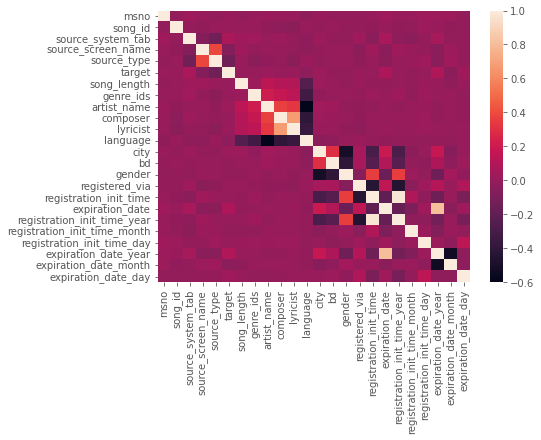

In [ ]:
plt.figure(figsize=[7,5])
sns.heatmap(encoded_df.corr())
plt.show()

In [ ]:
# Drop columns
encoded_df = encoded_df.drop(['expiration_date', 'lyricist'], 1)

In [ ]:
y = encoded_df['target']
X = encoded_df.drop(['target'],1)

In [ ]:
X.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,song_length,genre_ids,artist_name,composer,language,city,bd,gender,registered_via,registration_init_time,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,567,533,3,7,3,251040,56,1188,1698,3.0,3,18,1,9,1855,2015,3,29,2017,9,11
1,851,4006,3,7,4,205635,58,454,712,52.0,13,28,0,9,601,2010,6,8,2017,9,14
2,1832,1945,5,12,6,225094,58,1402,1509,3.0,1,0,2,7,1994,2015,9,12,2017,9,11
3,4627,3298,3,7,3,65933,31,113,980,17.0,1,0,2,7,1023,2012,1,10,2017,10,3
4,2857,5,1,10,5,224722,58,93,1923,17.0,1,0,2,4,2327,2016,10,30,2017,8,28


## Model: RandomForest classifier

In [ ]:
model = RandomForestClassifier(n_estimators=250, max_depth=25)
model.fit(X, y)

RandomForestClassifier(max_depth=25, n_estimators=250)

### Examine the Default Random Forest to Determine Parameters

In [ ]:
from pprint import pprint
print('Parameters currently in use:\n')
pprint(model.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 25,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 250,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


### Feature Importance

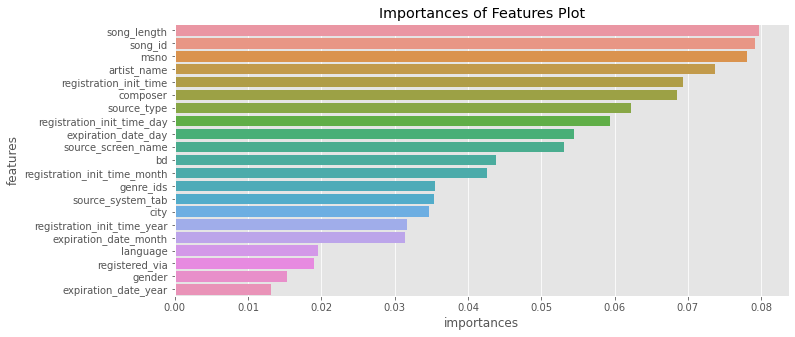

In [ ]:
df_plot = pd.DataFrame({'features': X.columns,
                        'importances': model.feature_importances_})
df_plot = df_plot.sort_values('importances', ascending=False)
plt.figure(figsize=[11,5])
sns.barplot(x = df_plot.importances, y = df_plot.features)
plt.title('Importances of Features Plot')
plt.show()

In [ ]:
# Drop columns with importances < 0.04
X = X.drop(df_plot.features[df_plot.importances < 0.04].tolist(), 1)

In [ ]:
X.columns

Index(['msno', 'song_id', 'source_screen_name', 'source_type', 'song_length',
       'artist_name', 'composer', 'bd', 'registration_init_time',
       'registration_init_time_month', 'registration_init_time_day',
       'expiration_date_day'],
      dtype='object')

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size = 0.20)

### Random Search with Cross Validation

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


## Hyperparameter tuning

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(train_data, train_labels)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


### Best Parameters

In [ ]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 1000}

## Evaluation Function

### Default Model

In [ ]:
base_model = RandomForestClassifier(n_estimators=250, max_depth=25)
base_model.fit(train_data, train_labels)
predict_labels = base_model.predict(test_data)
print(classification_report(test_labels, predict_labels))

              precision    recall  f1-score   support

         0.0       0.56      0.40      0.46       464
         1.0       0.74      0.84      0.79       944

    accuracy                           0.70      1408
   macro avg       0.65      0.62      0.63      1408
weighted avg       0.68      0.70      0.68      1408



### Best RandomSearch Model

In [ ]:
best_random_model = rf_random.best_estimator_
predict_labels = best_random_model.predict(test_data)
print(classification_report(test_labels, predict_labels))

              precision    recall  f1-score   support

         0.0       0.55      0.41      0.47       464
         1.0       0.74      0.84      0.79       944

    accuracy                           0.70      1408
   macro avg       0.65      0.62      0.63      1408
weighted avg       0.68      0.70      0.68      1408



## XGBoost

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size = 0.20)

## Hyperparameter Tuning

In [ ]:
# Create model

model = xgb.XGBClassifier()

# Create parameters grid

parameters_grid = { 'learning_rate' : [0.1, 0.2, 0.5], 'max_depth' : [5, 10, 15], 'n_estimators' : [150, 250, 300], 'min_child_weight' : [3, 5, 10] }

# Strategy of cross validation

cv = StratifiedShuffleSplit(n_splits= 3, test_size = 0.2)

# Create Randomized search Strategy

grid_cv = RandomizedSearchCV(model, parameters_grid, scoring = 'accuracy', cv = cv)

# Fit model by Grid

grid_cv.fit(train_data, train_labels)

# Model with the best estimator
print(grid_cv.best_estimator_)

XGBClassifier(max_depth=5, min_child_weight=5, n_estimators=300)


#### Best Parameters

In [ ]:
grid_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 5,
 'n_estimators': 300}

## Best XGBoost Model

In [ ]:
model = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=300)
model.fit(train_data, train_labels)

XGBClassifier(max_depth=5, min_child_weight=5, n_estimators=300)

## Evaluation

In [ ]:
# Predicting
predict_labels = model.predict(test_data)
print(classification_report(test_labels, predict_labels))

              precision    recall  f1-score   support

         0.0       0.57      0.37      0.45       474
         1.0       0.73      0.86      0.79       934

    accuracy                           0.70      1408
   macro avg       0.65      0.61      0.62      1408
weighted avg       0.68      0.70      0.67      1408

